# Import Libraries

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Datasets
Import both original and cvat dataset

In [ ]:
# Added dataset_15 to MyDrive as shortcut
import pathlib
original_dir = "/content/drive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15"
original_dir = pathlib.Path(original_dir)

cvat_dir = "/content/drive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15_cvat"
cvat_dir = pathlib.Path(cvat_dir)

image_count = len(list(original_dir.glob('*/*.png')))
print(image_count)

430


# Initialise Parameters

img_height and img_width: These parameters define the height and width, respectively, to which the input images will be resized during pre-processing. In this case, the images will be resized to 299x299 pixels, which is a common size used for many CNN architectures like InceptionV3 and Xception.

seed: The seed value is used to initialize the random number generator, ensuring reproducibility of the training process. Setting a specific seed value allows you to obtain the same random results in different runs, making it easier to compare and replicate experiments.

validation_split: This parameter determines the proportion of the training data that will be used for validation during model training. In this case, 20% of the training data will be reserved for validation, and the remaining 80% will be used for actual training.

epochs: The number of epochs specifies how many times the entire training dataset will be iterated during training. Each epoch consists of multiple batches, and the model updates its parameters based on the training data in each batch. In this case, the model will be trained for 60 epochs.

batch_size: The batch size refers to the number of samples that will be processed together in each iteration during training. A smaller batch size uses less memory but may slow down training due to more frequent updates. A larger batch size speeds up training but requires more memory. In this case, the batch size is set to 10.

learning_rate: The learning rate determines the step size in the optimization algorithm during model training. It controls how much the model's parameters are updated in response to the computed gradients. A smaller learning rate results in slower but more stable training, while a larger learning rate can lead to faster convergence but might be more prone to overshooting the optimal solution. In this case, the learning rate is set to 0.00001 (1e-5).

In [ ]:
# other paremeters
img_height = 299
img_width = 299
seed = 2000553

# models paremeter
validation_split = 0.2
epochs = 60
batch_size = 10
learning_rate = 0.00001

## Split dataset

In [ ]:
def split_dataset(data_dir):
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle =True
  )

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset = "validation",
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle =True
  )

  return train_ds,val_ds

## Display labels in original and CVAT directory
Verify data and ensure dataset is accurate

Original Dataset: 
Found 430 files belonging to 2 classes.
Using 344 files for training.
Found 430 files belonging to 2 classes.
Using 86 files for validation.
['covid', 'normal']


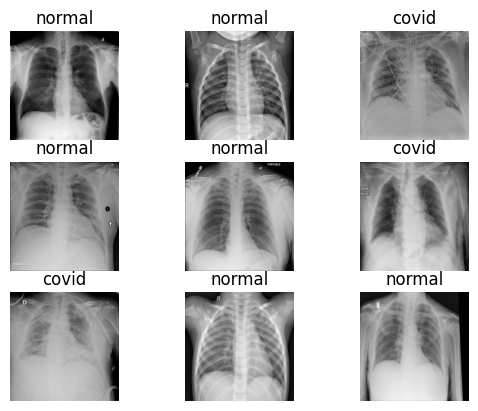

In [ ]:
def display_classes_label(class_name):
  for images, labels in original_train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_name[labels[i]])
      plt.axis("off")

print("Original Dataset: ")
original_train_ds, original_val_ds = split_dataset(original_dir)

original_ds_class_names = original_train_ds.class_names
print(original_ds_class_names)
display_classes_label(original_ds_class_names)

CVAT Dataset: 
Found 430 files belonging to 2 classes.
Using 344 files for training.
Found 430 files belonging to 2 classes.
Using 86 files for validation.
['covid', 'normal']


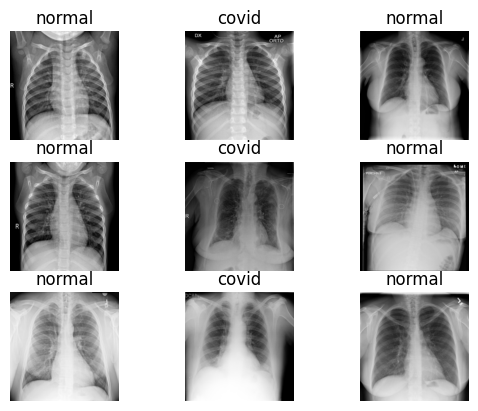

In [ ]:
print("CVAT Dataset: ")
cvat_train_ds, cvat_val_ds = split_dataset(cvat_dir)
cvat_class_names = cvat_train_ds.class_names
print(cvat_class_names)
display_classes_label(cvat_class_names)

# Create Custom DenseModel

DenseNet Model:

DenseNet is based on the concept of dense connectivity, where each layer receives input from all preceding layers in the block, resulting in dense feature reuse and direct information flow.The model consists of multiple dense blocks, each containing a series of convolutional layers with batch normalization and ReLU activation. A dense block typically contains a combination of 1x1 and 3x3 convolutional layers, which help in learning feature maps of different complexities and scales.

Between dense blocks, transition layers are added to reduce the spatial dimensions of feature maps and control the number of channels.Transition layers often involve a combination of 1x1 convolution and pooling (e.g., max pooling) to downsample the feature maps.The output of the last dense block is followed by global average pooling to reduce spatial dimensions into a global average value. The final layer of the DenseNet model is a fully connected layer with a softmax activation for multi-class classification tasks such as "normal" and "covid".

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
# Define the DenseNet block
def dense_block(x, growth_rate, num_layers):
    for _ in range(num_layers):
        # Each layer in the dense block
        # Consists of 1x1 convolution followed by 3x3 convolution
        # With batch normalization and ReLU activation
        conv1 = Conv2D(growth_rate, (1, 1), padding='same')(x)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)

        conv3 = Conv2D(growth_rate, (3, 3), padding='same')(conv1)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation('relu')(conv3)

        # Concatenate the output with the input
        x = Concatenate()([x, conv3])

    return x

# Define the custom DenseNet model
def custom_densenet(input_shape, num_classes, growth_rate=20, num_dense_blocks=8, num_layers_per_block=4):
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(16, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Dense blocks
    for i in range(num_dense_blocks):
        x = dense_block(x, growth_rate, num_layers_per_block)

    # Final part of the network
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)

    return model

# Assuming you have two classes in your dataset (binary classification)
# can use either label for original or cvat
num_classes = len(original_ds_class_names)

# Create the custom DenseNet model with the modified output layer for binary classification
original_model = custom_densenet((img_height, img_width, 3), num_classes)
cvat_model = custom_densenet((img_height, img_width, 3), num_classes)

# Create the optimizer with the specified learning rate for original_model
optimizer_original = Adam(learning_rate=learning_rate)

# Create the optimizer with the specified learning rate for cvat_model
optimizer_cvat = Adam(learning_rate=learning_rate)

# Compile the original_model with its optimizer, loss, and metrics
original_model.compile(optimizer=optimizer_original, loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the cvat_model with its optimizer, loss, and metrics
cvat_model.compile(optimizer=optimizer_cvat, loss='categorical_crossentropy', metrics=['accuracy'])

# model description
cvat_model.summary()

2


## Train original dataset

In [ ]:
# One-hot encode your labels for binary classification with two classes
def one_hot_encode(train_ds,val_ds):
  train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
  val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

  return train_ds, val_ds


# one hot encode both dataset for train and validation set
original_train_ds, original_val_ds = one_hot_encode(original_train_ds, original_val_ds)
cvat_train_ds, cvat_val_ds = one_hot_encode(cvat_train_ds, cvat_val_ds)

# Train the model
print("Original Dataset Accuracy/Loss: ")
original_model_history = original_model.fit(original_train_ds, validation_data=original_val_ds, epochs=epochs, batch_size=batch_size)

Original Dataset Accuracy/Loss: 
Epoch 1/60
35/35 [==============================] - 73s 401ms/step - loss: 0.6419 - accuracy: 0.5930 - val_loss: 0.7558 - val_accuracy: 0.5349
Epoch 2/60
35/35 [==============================] - 9s 252ms/step - loss: 0.6132 - accuracy: 0.6337 - val_loss: 0.7213 - val_accuracy: 0.5349
Epoch 3/60
35/35 [==============================] - 10s 269ms/step - loss: 0.5922 - accuracy: 0.6948 - val_loss: 0.7106 - val_accuracy: 0.5349
Epoch 4/60
35/35 [==============================] - 9s 242ms/step - loss: 0.5829 - accuracy: 0.7035 - val_loss: 0.7054 - val_accuracy: 0.5349
Epoch 5/60
35/35 [==============================] - 8s 234ms/step - loss: 0.5642 - accuracy: 0.7267 - val_loss: 0.7012 - val_accuracy: 0.5465
Epoch 6/60
35/35 [==============================] - 9s 255ms/step - loss: 0.5600 - accuracy: 0.7471 - val_loss: 0.6990 - val_accuracy: 0.6163
Epoch 7/60
35/35 [==============================] - 9s 254ms/step - loss: 0.5481 - accuracy: 0.7500 - val_loss: 0

## Train CVAT dataset

In [ ]:
# Train the model
print("CVAT Dataset Accuracy/Loss: ")
cvat_model_history = cvat_model.fit(cvat_train_ds, validation_data=cvat_val_ds, epochs=epochs, batch_size=batch_size)

CVAT Dataset Accuracy/Loss: 
Epoch 1/60
35/35 [==============================] - 113s 2s/step - loss: 0.6705 - accuracy: 0.5930 - val_loss: 0.7152 - val_accuracy: 0.5465
Epoch 2/60
35/35 [==============================] - 9s 249ms/step - loss: 0.6378 - accuracy: 0.5959 - val_loss: 0.7008 - val_accuracy: 0.5930
Epoch 3/60
35/35 [==============================] - 9s 244ms/step - loss: 0.6126 - accuracy: 0.6221 - val_loss: 0.6929 - val_accuracy: 0.6744
Epoch 4/60
35/35 [==============================] - 9s 246ms/step - loss: 0.5932 - accuracy: 0.6744 - val_loss: 0.6858 - val_accuracy: 0.5233
Epoch 5/60
35/35 [==============================] - 9s 236ms/step - loss: 0.5794 - accuracy: 0.7006 - val_loss: 0.6817 - val_accuracy: 0.5814
Epoch 6/60
35/35 [==============================] - 9s 257ms/step - loss: 0.5740 - accuracy: 0.7006 - val_loss: 0.6694 - val_accuracy: 0.6512
Epoch 7/60
35/35 [==============================] - 9s 254ms/step - loss: 0.5620 - accuracy: 0.7122 - val_loss: 0.6649 -

# Performance Evaluation
Both the training accuracy for the original and cvat model performs similarly begins from an accuracy of 60 to 85%, which means that both models are able to learn and capture the patterns of the training dataset for both “covid” and “normal” images with a dataset size of 344 images in training folder. Under training loss, as the epoch increases, the model is also improving with each epoch as the loss accuracy decreases from 65 to 35% overtime which indicates that the model is able to predict the actual ground truth values of the training data.

Under validation accuracy, the original model performs better than the cvat model with the highest accuracy of 80% as compared to 72% and it performs better with a lowest validation loss of 50% as compared to cvat model with 57% which indicates that the original model is better at predicting unseen data. Based on the results, reasons may include cvat model not being able to detect features in the dataset because of the enlarged images that causes biases during training.


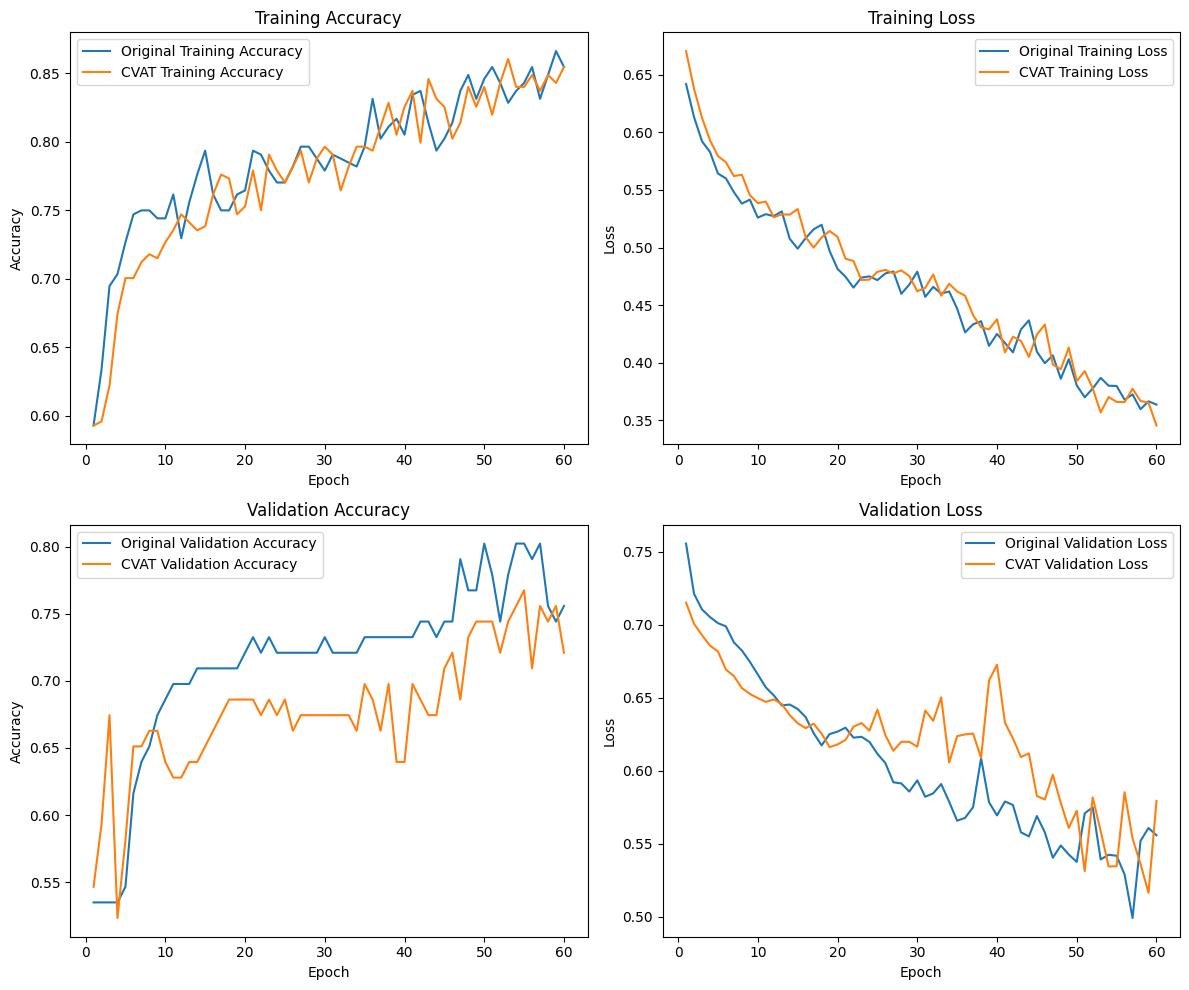

In [ ]:
def plot_training_histories(original_history, cvat_history):
    plt.figure(figsize=(12, 10))

    # Training Accuracy (Original and CVAT)
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(original_history.history['accuracy']) + 1), original_history.history['accuracy'], label='Original Training Accuracy')
    plt.plot(range(1, len(cvat_history.history['accuracy']) + 1), cvat_history.history['accuracy'], label='CVAT Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='upper left')  # Position legend at top-left corner

    # Training Loss (Original and CVAT)
    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(original_history.history['loss']) + 1), original_history.history['loss'], label='Original Training Loss')
    plt.plot(range(1, len(cvat_history.history['loss']) + 1), cvat_history.history['loss'], label='CVAT Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')  # Position legend at top-right corner

    # Validation Accuracy (Original and CVAT)
    plt.subplot(2, 2, 3)
    plt.plot(range(1, len(original_history.history['val_accuracy']) + 1), original_history.history['val_accuracy'], label='Original Validation Accuracy')
    plt.plot(range(1, len(cvat_history.history['val_accuracy']) + 1), cvat_history.history['val_accuracy'], label='CVAT Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend(loc='upper left')  # Position legend at top-left corner

    # Validation Loss (Original and CVAT)
    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(original_history.history['val_loss']) + 1), original_history.history['val_loss'], label='Original Validation Loss')
    plt.plot(range(1, len(cvat_history.history['val_loss']) + 1), cvat_history.history['val_loss'], label='CVAT Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend(loc='upper right')  # Position legend at top-right corner

    # Adjust spacing and avoid overlapping
    plt.tight_layout()
    plt.show()

plot_training_histories(original_model_history, cvat_model_history)


# Plot Model Results
Display comparison results for both models in pairs for first batch of data (9 pairs)

In [ ]:
import matplotlib.patches as patches

def plot_results(original_val_ds, cvat_val_ds, model):
    # Function to decode the predicted classes (same as provided before)
    def decode_prediction(predictions):
        class_names = ["covid", "normal"]  # Replace with your actual class names
        predicted_classes = tf.argmax(predictions, axis=1)
        decoded_predictions = [class_names[pred] for pred in predicted_classes.numpy()]
        return decoded_predictions

    # Define different colors for the rectangles around each pair of images
    rect_colors = ['r', 'g']
    rect_linewidth = 10  # Increase the border thickness

    # Plot the images along with their predicted classes in a 1x2 grid (side by side)
    plt.figure(figsize=(20, 20))  # Make the figure wider to accommodate both plots side by side
    count = 0

    for (images_orig, labels_orig), (images_cvat, labels_cvat) in zip(original_val_ds, cvat_val_ds):
        predictions_orig = model.predict(images_orig)
        decoded_predictions_orig = decode_prediction(predictions_orig)

        predictions_cvat = model.predict(images_cvat)
        decoded_predictions_cvat = decode_prediction(predictions_cvat)

        for i in range(len(images_orig)):
            count += 1
            if count <= 18:
                # Plot images and their predicted classes side by side
                plt.subplot(6, 6, count)  # Use 6 rows and 6 columns for 18 images
                plt.imshow(images_orig[i].numpy().astype("uint8"))
                plt.title("Original " + decoded_predictions_orig[i])
                plt.axis("off")

                # Draw a rectangle around the first image from each validation dataset
                ax = plt.gca()
                rect = patches.Rectangle((0, 0), img_width, img_height, linewidth=rect_linewidth, edgecolor=rect_colors[0], facecolor='none')
                ax.add_patch(rect)

                count += 1
                if count <= 18:
                    plt.subplot(6, 6, count)  # Use 6 rows and 6 columns for 18 images
                    plt.imshow(images_cvat[i].numpy().astype("uint8"))
                    plt.title("CVAT " + decoded_predictions_cvat[i])
                    plt.axis("off")

                    # Draw a rectangle around the first image from each validation dataset
                    ax = plt.gca()
                    rect = patches.Rectangle((0, 0),img_width, img_height, linewidth=rect_linewidth, edgecolor=rect_colors[1], facecolor='none')
                    ax.add_patch(rect)
            else:
                break

    plt.show()

##Original Model Predictions:

Test original model with original and cvat validation dataset.

1/1 [==============================] - 0s 30ms/step


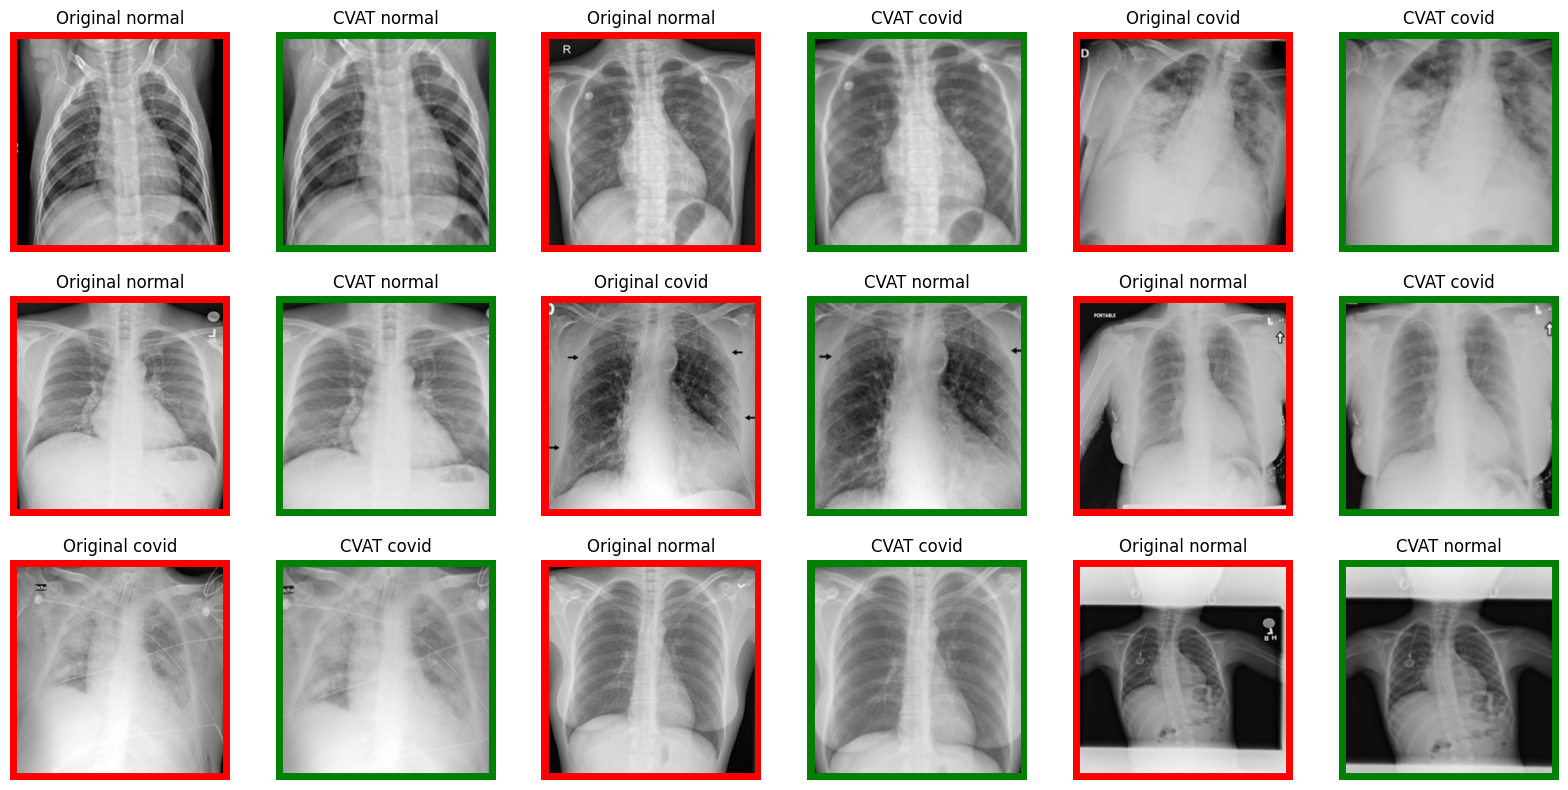

In [ ]:
plot_results(original_val_ds, cvat_val_ds, original_model)

## CVAT Model Predictions:

Test cvat model with original and cvat validation dataset.

1/1 [==============================] - 0s 29ms/step


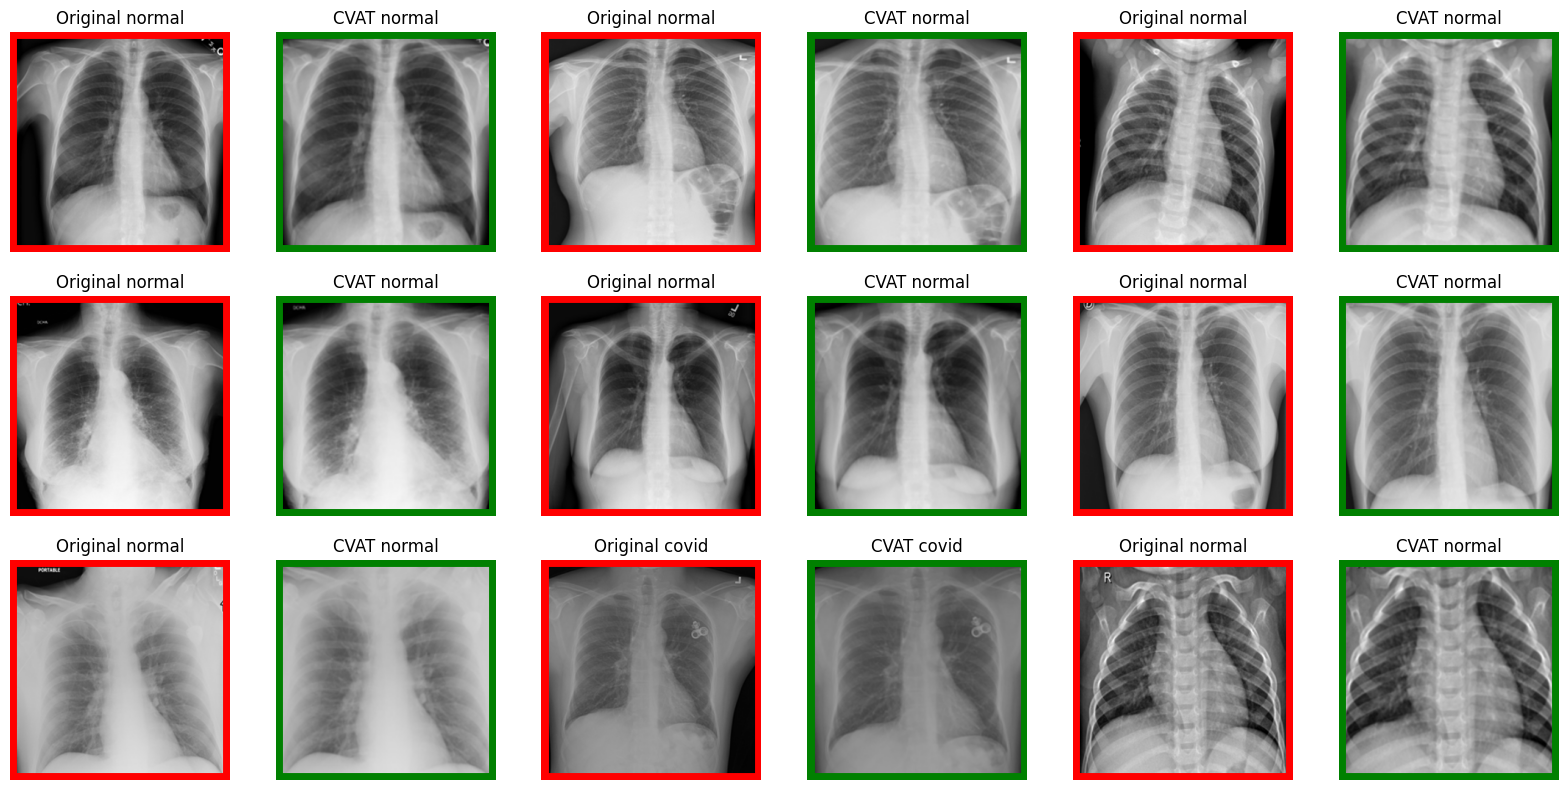

In [ ]:
plot_results(original_val_ds, cvat_val_ds, cvat_model)